In [ ]:
import scanpy as sc 
import pandas as pd
import numpy as np
from age_map import age_label_mapping_10
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
adata = sc.read_h5ad("chunk3562_stress_tumor_repair2.h5ad")

### Fig 3: cell-type-specific age predictions

In [ ]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
ref_cell_types = ['astrocyte','regulatory T cell','oligodendrocyte precursor cell',
                    'central memory CD4-positive, alpha-beta T cell',
                    'B cell','macrophage']
filtered_data = data[data['Cell Type'].isin(ref_cell_types)]

In [ ]:
for cell_type in ref_cell_types:
    subset = filtered_data[filtered_data["Cell Type"] == cell_type]
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x="Ground Truth Age",
        y="Predicted Age",
        data=subset,
        ci=None,
        scatter_kws={"s": 20, "color": "blue"},
        line_kws={"color": "black"},
    )
    
    correlation = cal_z_score(subset["Ground Truth Age"], subset["Predicted Age"])["r_value"]
    if pd.notna(correlation):
        plt.text(
            0.05,
            0.9,
            f'R = {correlation:.2f}',
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.8),
            color="black",
        )
        formatted_title = cell_type.replace("-positive", "+").replace("alpha-beta", "")
    plt.title(f"{formatted_title} age predictions", fontsize=16)
    plt.xlabel("chronological age")
    plt.ylabel("predicted age")
    
    plt.savefig(f"paper_plots/cell_type_age_predictions/{cell_type}_healthy_samples.png", dpi=300, bbox_inches='tight')
    plt.close()
    #plt.show()

### Figure 4: Similarity between cell type token and age token

In [ ]:
import os
import tqdm

obs_df = []
tissue_embeddings = []
age_embeddings = []
cell_type_embeddings = []
path = '/media/lleger/LaCie/age_cage/'
for file in tqdm.tqdm(os.listdir('/media/lleger/LaCie/age_cage/')):
    if file.startswith("phenotype"):
        chunk = sc.read_h5ad(path + file)
        obs_df.append(chunk.obs)
        tissue_embeddings.append(chunk.uns['tissue_embeddings'])
        age_embeddings.append(chunk.uns['age_embeddings'])
        cell_type_embeddings.append(chunk.uns['cell_type_embeddings'])

obs_df = pd.concat(obs_df)
tissue_embeddings = np.concatenate(tissue_embeddings)
age_embeddings = np.concatenate(age_embeddings)
cell_type_embeddings = np.concatenate(cell_type_embeddings)

100%|██████████| 79/79 [00:02<00:00, 31.40it/s]


In [ ]:
obs_df.shape

(130000, 29)

In [ ]:
healthy_mask = obs_df["disease"] == "normal"
age_embeddings = age_embeddings[healthy_mask]
cell_type_embeddings = cell_type_embeddings[healthy_mask]
cell_types = obs_df["cell_type"][healthy_mask]

celltype_age_sims = sim_celltype_age(cell_type_embeddings, age_embeddings, cell_types)

/tmp/ipykernel_1765454/1855414366.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma_r")


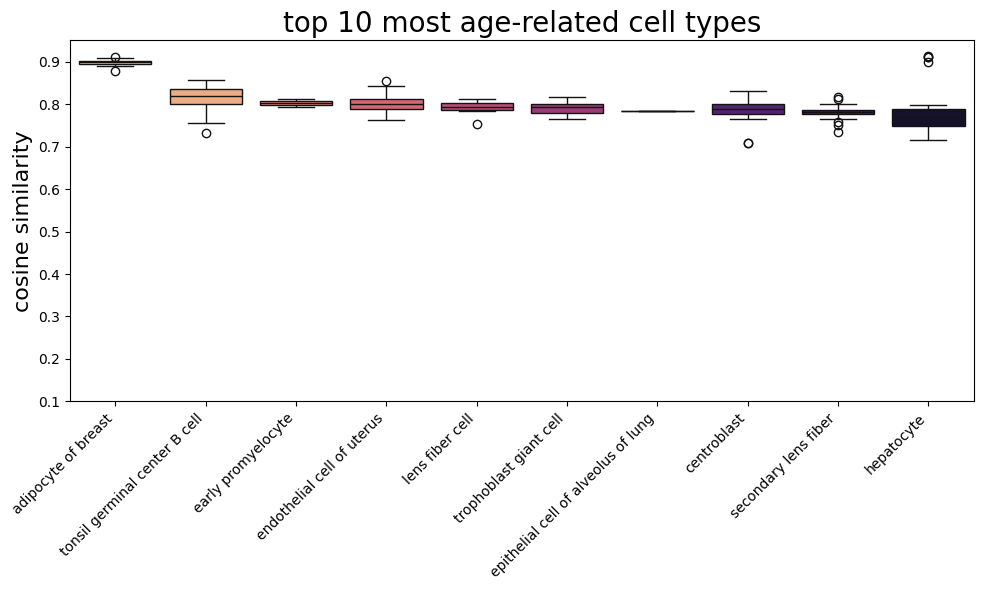

In [ ]:
top10 = sorted(celltype_age_sims.items(), key=lambda x: np.mean(x[1]), reverse=True)[:10]
plot_data = {
    'cell type': [],
    'cosine similarity': []
}
for cell_type, cosine_similarity_values in top10:
    plot_data['cell type'].extend([cell_type] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_top10age-celltype.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma_r")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.title('top 10 most age-related cell types',fontsize=20)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.tight_layout()
#plt.show()
plt.savefig("top10relatedcelltypes.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1765454/1492004468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma")


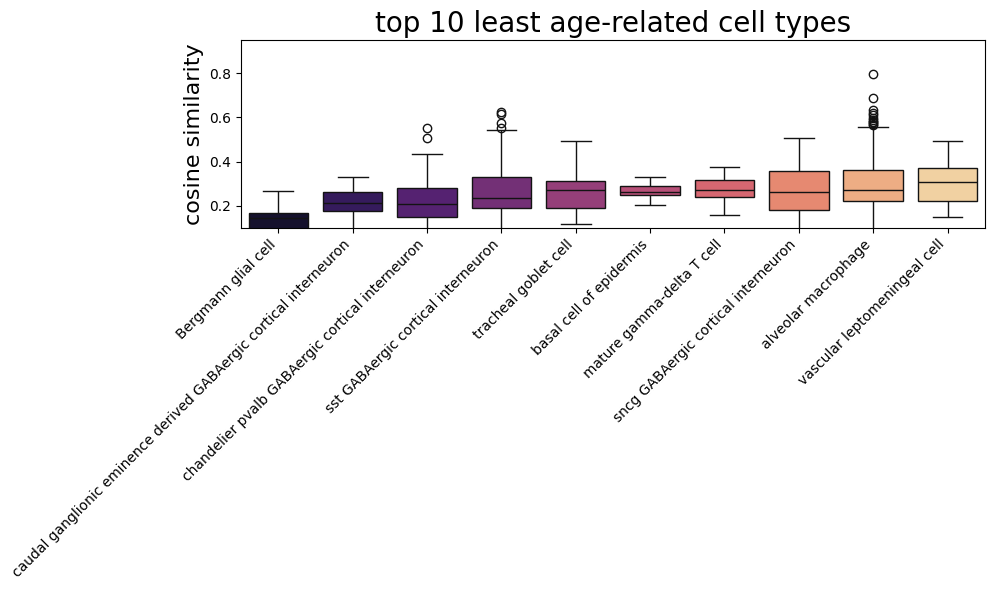

In [ ]:
top10 = sorted(celltype_age_sims.items(), key=lambda x: np.mean(x[1]))[:10]
plot_data = {
    'cell type': [],
    'cosine similarity': []
}
for cell_type, cosine_similarity_values in top10:
    plot_data['cell type'].extend([cell_type] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_last10age-celltype.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.title('top 10 least age-related cell types',fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig("leastrelatedcells.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
tissue_embeddings = tissue_embeddings[healthy_mask]
tissues = obs_df["tissue"][healthy_mask]

tissue_age_sims = sim_tissue_age(tissue_embeddings, age_embeddings, tissues)

/tmp/ipykernel_1765454/1584246881.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tissue', y='cosine similarity', data=df, palette="magma_r")


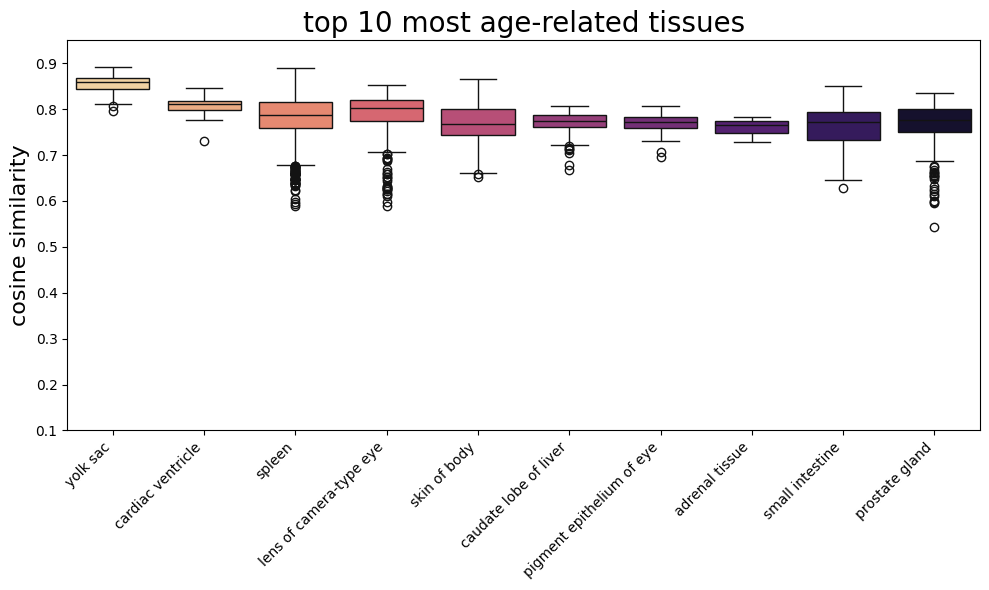

In [ ]:
top10 = sorted(tissue_age_sims.items(), key=lambda x: np.mean(x[1]), reverse=True)[:10]
plot_data = {
    'tissue': [],
    'cosine similarity': []
}
for tissue, cosine_similarity_values in top10:
    plot_data['tissue'].extend([tissue] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_top10age-tissue.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='tissue', y='cosine similarity', data=df, palette="magma_r")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.title('top 10 most age-related tissues',fontsize=20)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.tight_layout()
#plt.show()
plt.savefig("top10tissue.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1765454/2908826358.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tissue', y='cosine similarity', data=df, palette="magma")


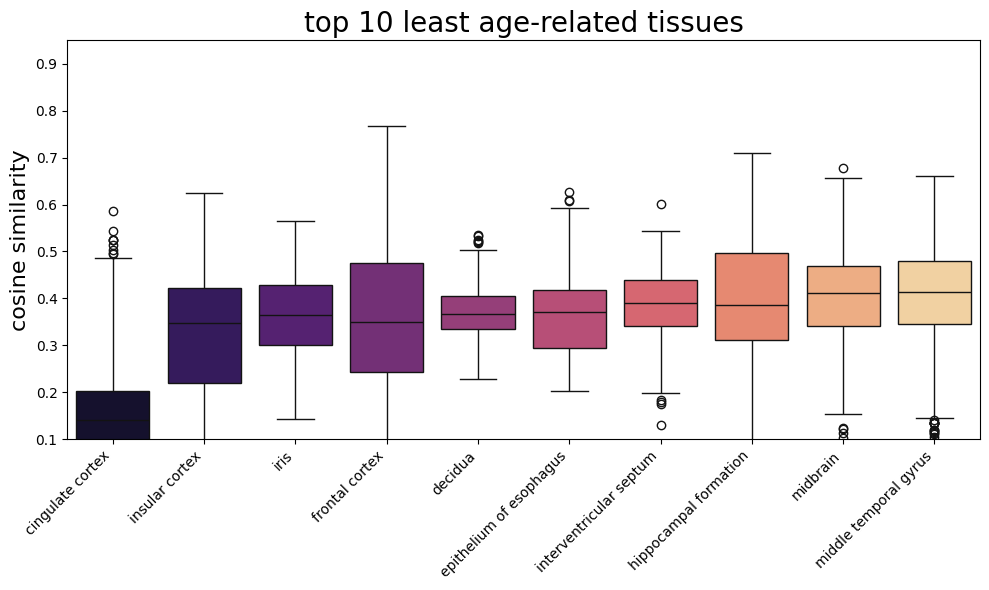

In [ ]:
top10 = sorted(tissue_age_sims.items(), key=lambda x: np.mean(x[1]))[:10]
plot_data = {
    'tissue': [],
    'cosine similarity': []
}
for tissue, cosine_similarity_values in top10:
    plot_data['tissue'].extend([tissue] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_last10age-tissue.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='tissue', y='cosine similarity', data=df, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.title('top 10 least age-related tissues',fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig("least10tissue.png", dpi=300, bbox_inches='tight')
plt.show()

### Fig 5: Dynamics of changes in aging using z-scored age gap

In [ ]:
obs_df_cut = obs_df.dropna(subset=['age', 'age_pred'])
ground_truth =obs_df_cut["age"]
predictions = obs_df_cut["age_pred"]

df = pd.DataFrame({
    'Ground Truth': ground_truth,
    'Prediction': predictions
})

df = df[(df['Prediction'] != -1) & (df["Ground Truth"] != -1)]

df['Age Gap'] = df['Prediction'] - df['Ground Truth']
df = df[df['Age Gap'] != 0]
res = cal_z_score(df['Ground Truth'], df['Prediction'], cal_r=False)
df['Z-Score'] = res["z_score"]
df.head(5)

,Ground Truth,Prediction,Age Gap,Z-Score
index_soma_joinid,,,,
50251263,51.0,64.0,13.0,0.715118
42799092,85.0,65.0,-20.0,-1.193684
44448590,19.0,66.0,47.0,2.681763
17373421,59.0,37.0,-22.0,-1.309369
17370219,30.0,31.0,1.0,0.021008


0        50-55
1        85-90
2        15-20
3        55-60
4        30-35
         ...  
33718    40-45
33719    40-45
33720    85-90
33721    65-70
33722    45-50
Name: Age Gap Range, Length: 33723, dtype: category
Categories (17, object): ['10-15' < '15-20' < '20-25' < '25-30' ... '75-80' < '80-85' < '85-90' < '90-95']

/tmp/ipykernel_1765454/2605081982.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")
/tmp/ipykernel_1765454/2605081982.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")


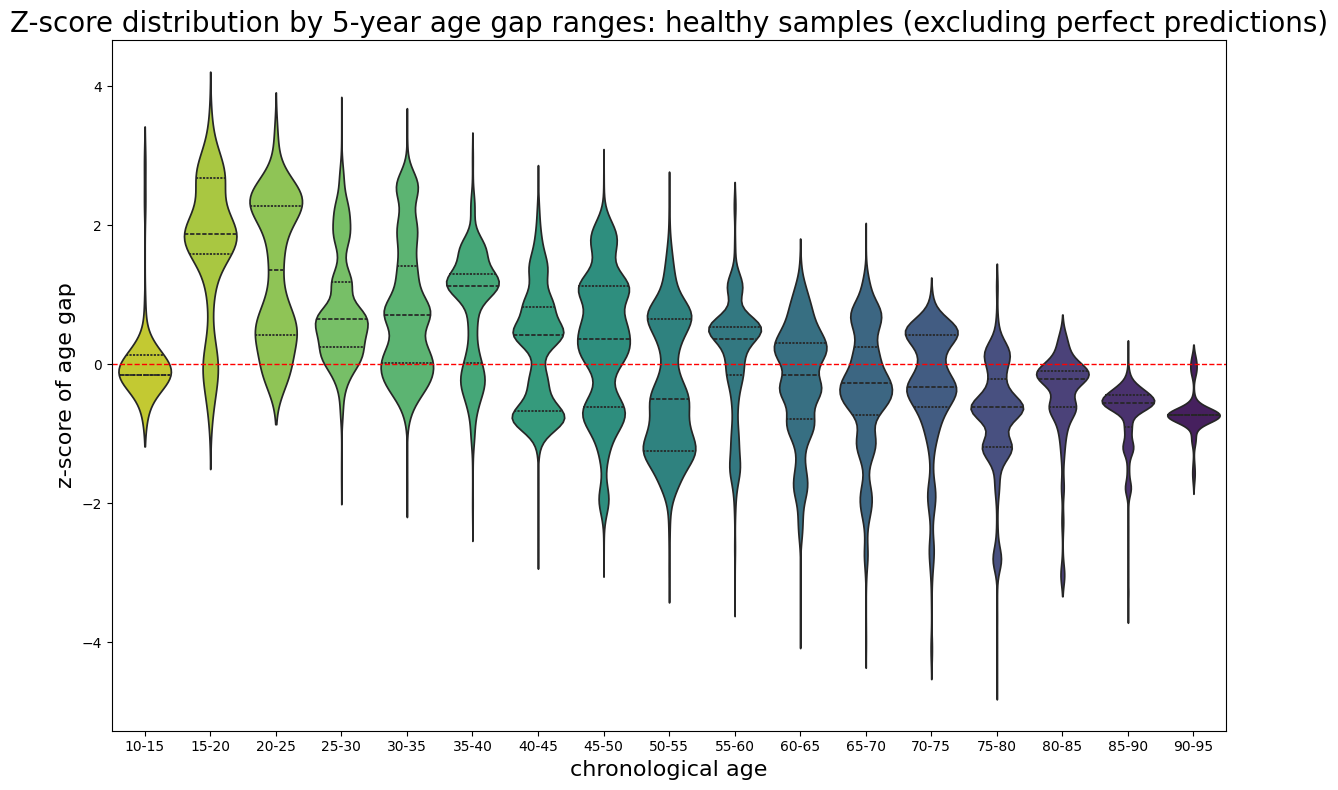

In [ ]:
bins = range(10, 100, 5)  # 0-5, 5-10, ..., 95-100
labels = [f"{i}-{i+5}" for i in bins[:-1]]
df = df[df["Ground Truth"] > 10].reset_index(drop=True)
df['Age Gap Range'] = pd.cut(df['Ground Truth'], bins=bins, labels=labels, right=False)

display(df["Age Gap Range"])
plt.figure(figsize=(12, 8))
sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Z-score distribution by 5-year age gap ranges: healthy samples (excluding perfect predictions)',fontsize=20)
plt.xlabel('chronological age',fontsize=16)
plt.ylabel('z-score of age gap',fontsize=16)
plt.tight_layout()
#plt.show()
plt.savefig("5year.png", dpi=300, bbox_inches='tight')
plt.show()

### Fig 6: Tissue-dependent and cell-type-specific aging dynamics

### blood lack:[3562-3570], brain lack [might not be complete: 3562, 3563, 3573, lack: 3574]

In [ ]:
ref_chunks = range(3562,3575)
for_these_tissues = ['liver', 'heart','lung', 'kidney', 'breast']#,'blood',"brain"] # 'bone marrow' is not included because all are <1 year old
age_count = {}
for tissue in for_these_tissues:
    age_count[tissue] = {}
    for chunk in ref_chunks:
        validation_data = sc.read_h5ad(f"/storage_bizon/sabrant_rocket_2tb/farhan/cellxgene/primary/cxg_chunk{chunk}.h5ad")
        validation_data.obs["age_group"] = validation_data.obs["development_stage"].map(age_label_mapping_10)
        filtered_data = validation_data[((validation_data.obs['tissue_general'] == tissue)) 
                                        & (validation_data.obs["disease"] == "normal")
                                        & (validation_data.obs["age_group"] != "unknown")]
        chunk_age_counts = filtered_data.obs["age_group"].value_counts()
        for age_group, sample_count in chunk_age_counts.items():
            if age_group in age_count[tissue]:
                age_count[tissue][age_group] += sample_count
            else:
                age_count[tissue][age_group] = sample_count

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Tran

In [ ]:
from collections import defaultdict
import pickle
sim_genes_by_age_by_tissue = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for chunk in ref_chunks:
    for tissue in for_these_tissues:
        file_path = f"/home/yufan/perturbgene/notebooks/general_tissue_{tissue}_genes_by_age/{tissue}_chunk{chunk}_by_age.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            if data is {}:
                print(f"sth wrong with {file_path}")
            for gene, age_dict in data.items():
                for age, values in age_dict.items():
                    age_range = age_label_mapping_10[age]
                    if age_range != "unknown":
                        sim_genes_by_age_by_tissue[tissue][age_range][gene].extend(values)

In [ ]:
from utils import top_n_genes_by_age
top3genes_by_age_by_tissue = top_n_genes_by_age(sim_genes_by_age_by_tissue,age_count)
df = pd.DataFrame([
    {'Tissue': tissue, 'Age': age, "Gene": gene, "Other Gene Name": gene, 'Mean Cosine Similarites': values}
    for tissue, age_dict in top3genes_by_age_by_tissue.items()
    for age, gene_values in age_dict.items()
    for gene,values in gene_values.items()
])
#df.to_csv("tissue_top3genes.csv", index=False)
df.head(5)

,Tissue,Age,Gene,Other Gene Name,Mean Cosine Similarites
0,liver,>80,MZT1P2,MZT1P2,0.672035
1,liver,>80,EEF1A1P33,EEF1A1P33,0.656566
2,liver,>80,RP3-477O4.5,RP3-477O4.5,0.654520
3,liver,60-70,RPS12,RPS12,0.402485
4,liver,60-70,CH17-258A22.4,CH17-258A22.4,0.401862


In [ ]:
df = pd.read_csv("tissue_top3genes.csv")
updated_gene_names = {}
for _, row in df.iterrows():
    if row["Gene"] != row["Other Gene Name"]:
        updated_gene_names[row["Gene"]] = row["Other Gene Name"]

In [ ]:
from utils import plot_clock_tissue, replace_innermost_keys
new_top3genes_by_age_by_tissue = replace_innermost_keys(top3genes_by_age_by_tissue, updated_gene_names)
for tissue in for_these_tissues:
    fig = plot_clock_tissue(tissue, new_top3genes_by_age_by_tissue)
    #fig.show()
    fig.savefig(f'paper_plots/clock_expressed_in1%_samples/{tissue}_clock.png', dpi=300, bbox_inches='tight')
    plt.close(fig)